In [1]:
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn import *
import pandas as pd

df = pd.read_csv("../treedata2.csv")
df = df.drop(columns=["ObjectID", "Other.1"], axis=1)

# One-hot encode categorical columns
categorical_cols = ["Tree Species", "Condition", "Site Factors", "Type of Soil", "Weather factors", "Failed Part", "Root Failure", "Stem Failure", "Branch Failure", "Location and Percentage of Decay", "Decay Present"]
df = pd.get_dummies(df, columns=categorical_cols)

# Convert one-hot encoded columns to integers
one_hot_cols = [col for col in df.columns if col.startswith(tuple(categorical_cols))]
df[one_hot_cols] = df[one_hot_cols].applymap(lambda x: int(x))

print(df.head())

C:\Users\eoinm\AppData\Local\Temp\ipykernel_24464\2158798669.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[one_hot_cols] = df[one_hot_cols].applymap(lambda x: int(x))


   Diameter of Tree  Height of Tree  Diameter of Failed Part  \
0                27              90                        5   
1                34              40                       12   
2                30             135                       30   
3                30             110                       30   
4                14              25                       14   

   Length of Failed Part  Tree Species_AbiesGrandis  \
0                   20.0                          0   
1                   40.0                          0   
2                  135.0                          0   
3                  110.0                          0   
4                   25.0                          0   

   Tree Species_AcerCircinatum  Tree Species_AcerMacrophyllum  \
0                            0                              0   
1                            0                              1   
2                            0                              0   
3                       

In [4]:
%pip install seaborn
%pip install matplotlib

Root Failure Model Accuracy: 75.50%
Stem Failure Model Accuracy: 61.59%
Branch Failure Model Accuracy: 68.87%

Root Failure Confusion Matrix:
[[91  7]
 [30 23]]

Stem Failure Confusion Matrix:
[[76 30]
 [28 17]]

Branch Failure Confusion Matrix:
[[70 28]
 [19 34]]


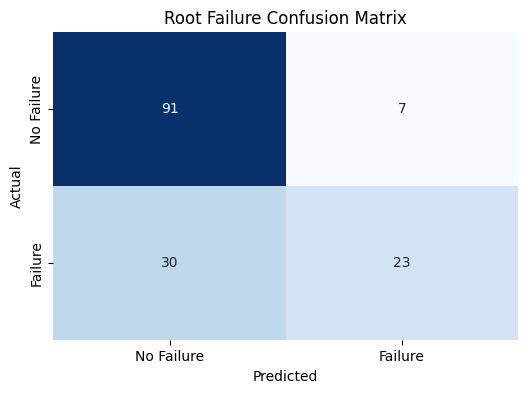

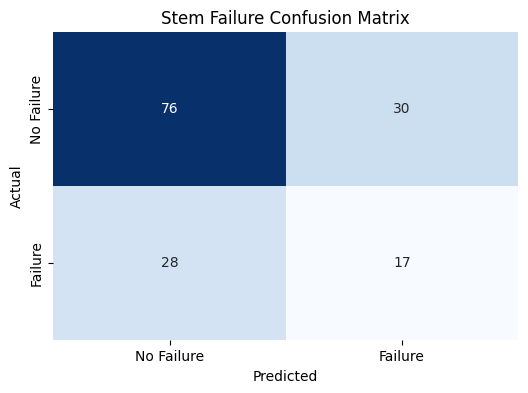

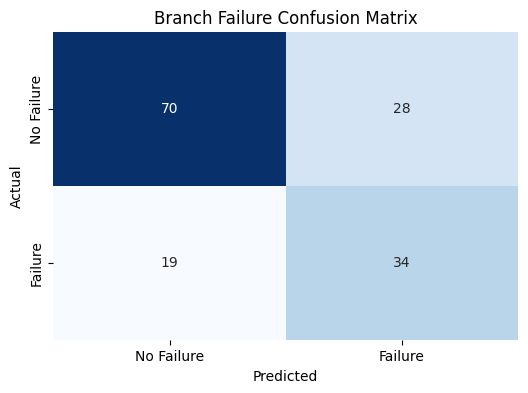

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 5: Preprocessing - Drop the 'Failed Part' columns as they are already encoded
X = df.drop(columns=["Failed Part_BranchFailure", "Failed Part_RootFailure", "Failed Part_StemFailure"])

# Step 7: Standardize the data (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 8: Define the function to train KNN model and evaluate
def train_knn_model(X, y, n_neighbors=5):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a KNN classifier model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Fit the model to the training data
    knn.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = knn.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred, y_test

# Step 9: Train classifiers for Root Failure, Stem Failure, and Branch Failure

# Root Failure (Target: Failed Part_RootFailure)
y_root = df['Failed Part_RootFailure']
accuracy_root, y_pred_root, y_test_root = train_knn_model(X_scaled, y_root)

# Stem Failure (Target: Failed Part_StemFailure)
y_stem = df['Failed Part_StemFailure']
accuracy_stem, y_pred_stem, y_test_stem = train_knn_model(X_scaled, y_stem)

# Branch Failure (Target: Failed Part_BranchFailure)
y_branch = df['Failed Part_BranchFailure']
accuracy_branch, y_pred_branch, y_test_branch = train_knn_model(X_scaled, y_branch)

# Step 10: Display the results
print(f"Root Failure Model Accuracy: {accuracy_root * 100:.2f}%")
print(f"Stem Failure Model Accuracy: {accuracy_stem * 100:.2f}%")
print(f"Branch Failure Model Accuracy: {accuracy_branch * 100:.2f}%")

# Step 11: Optionally, display the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

print("\nRoot Failure Confusion Matrix:")
print(confusion_matrix(y_test_root, y_pred_root))

print("\nStem Failure Confusion Matrix:")
print(confusion_matrix(y_test_stem, y_pred_stem))

print("\nBranch Failure Confusion Matrix:")
print(confusion_matrix(y_test_branch, y_pred_branch))

# Step 12: Visualize the confusion matrices (optional)
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(confusion_matrix(y_test_root, y_pred_root), "Root Failure Confusion Matrix")
plot_confusion_matrix(confusion_matrix(y_test_stem, y_pred_stem), "Stem Failure Confusion Matrix")
plot_confusion_matrix(confusion_matrix(y_test_branch, y_pred_branch), "Branch Failure Confusion Matrix")

In [ ]:
df["Failed Part_BranchFailure"]
df["Failed Part_RootFailure"]
df["Failed Part_StemFailure"]

,Diameter of Tree,Height of Tree,Diameter of Failed Part,Length of Failed Part,Tree Species_AbiesGrandis,Tree Species_AcerCircinatum,Tree Species_AcerMacrophyllum,Tree Species_AcerPalmatum,Tree Species_AcerPlatanoides,Tree Species_AcerRubrum,...,Decay Present_PhaeolusSchweinitzii,"Decay Present_PhaeolusSchweinitzii,HeterobasidionOccidentale","Decay Present_PhaeolusSchweinitzii,PhellinusHartigii","Decay Present_PhaeolusSchweinitzii,PorodadaleaPini","Decay Present_PhellinusHartigii,PhaeolusSchweinitzii",Decay Present_PhellinusWeirii,Decay Present_PhytophthoraCactorum,"Decay Present_PhytophthoraCactorum,KretzchmariaDuesta",Decay Present_PhytophthoraCinnamomii,Decay Present_PorodadaleaPini
0,27,90,5,20.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34,40,12,40.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,135,30,135.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,110,30,110.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14,25,14,25.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
